In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from lmfit import Model
import tqdm
from astropy.constants import M_sun


sys.path.append('../my_funcs/')
from pipeline_main import pipeline
sys.path.append('../my_python_utilities')
from basic_units import cos, degrees, radians


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## There are 2 ways of calculating the scale height: the easy and the ambitious.
### 1. The disk is flat and the scale height is simply:
### $$\frac{H_p}{r}=\frac{c_s^{iso}}{\Omega_K}$$
### $$\langle c_s \rangle = \frac{P}{\rho}$$ 
### 2. One can also make a fit from the the densities in $r +\Delta r$ cylindrical rings to the function below
### $$\rho(r,z)=\frac{\Sigma_g(r)}{\sqrt{2\pi}H_p}  \exp{(-z^2/2H_p^2)}$$ (Armitage p. 71)
### $$\Rightarrow \ln(\rho)(r,z)=const - \frac{z^2}{2H_p^2}$$

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4903/4903 [00:06<00:00, 816.18it/s]


24079071.269963015
Converged mean angular momentum vector after 2 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4903/4903 [00:00<00:00, 23330.95it/s]


Disk size: 10.2 au


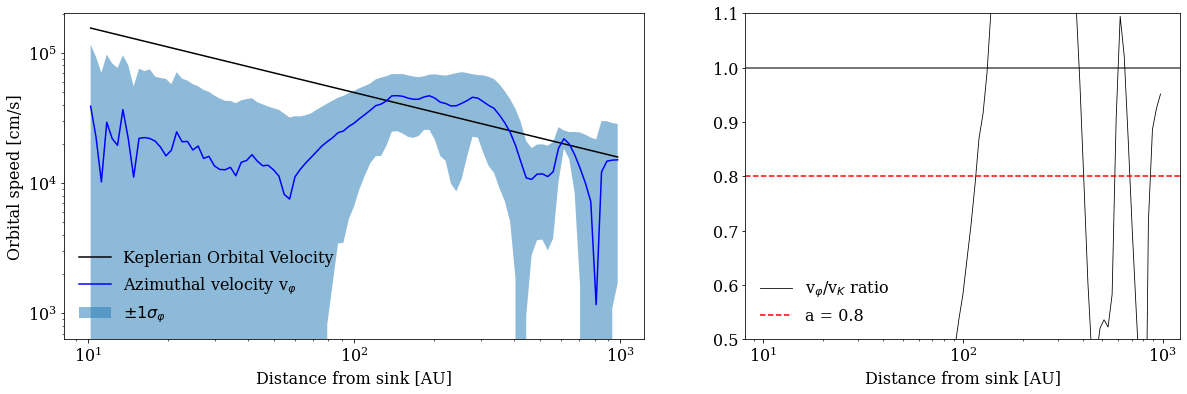

In [3]:
data = pipeline(snap = 449, run = 'sink225core03', sink_id =225)
print(data.time)
data.recalc_L(verbose = 1)
data.calc_disksize()

In [4]:
def Hp_func(x, Σ, H): return (Σ) / (np.sqrt(2 * np.pi) * H) * np.exp( - x**2 / (2 * H**2)) 

def fit_scaleheight(ρ, h, x0):
    model = Model(Hp_func)
    params = model.make_params(Σ = x0[0], H = x0[1])
    #params['Σ'].min = 1.175494e-38; params['H'].min =  1.175494e-38   # Ensure H is always positive
    result = model.fit(ρ, x = h, params = params)
    fit_params = np.array(list(result.best_values.values()))
    fit_err = np.array([par.stderr for _, par in result.params.items()])
    fit_params[0] *= data.sn.cgs.au ; fit_err[0] *= data.sn.cgs.au

    return fit_params, fit_err

In [5]:
data.sn.cgs.au / 1e10

1496.0

In [6]:
Nr = 100
r_grid = np.logspace(np.log10(5), np.log10(100), Nr) / data.au_length #[au]
r_grid_mid = r_grid[:-1] + 0.5 * np.diff(r_grid) 

densities = {key: [] for key in range(Nr - 1)}
heights = {key: [] for key in range(Nr - 1)}

for p in tqdm.tqdm(data.sn.patches):
    bins_idx = np.digitize(p.cyl_R, bins = r_grid)                                   #Assigning each point to their repective bin 
    if (bins_idx == Nr).all() or (bins_idx == 0).all(): continue                    #If the points are outside of the given bin the index is 0 or 25 (dependent on the length of radial bins)
    for bin in np.unique(bins_idx):
        if bin == 0 or bin == Nr: continue                                            
        h_idx = np.nonzero(abs(p.cyl_z.flatten()) < 2 * r_grid_mid[bin - 1])             # Now I make a cut only taking cells within 2 * the radial bins. I want the densities directory to be 0-indexet hence bin - 1
        if len(h_idx) == 0: continue                                             
        b_idx = np.nonzero(bins_idx.flatten() == bin)                                #Only look at the cells that goes into the specific bin    
        intersec = np.intersect1d(h_idx, b_idx)                                      #Only use the intersection of indicies between bin of the radial grid and the height
        
        densities[bin - 1].extend(p.var('d').flatten()[intersec])
        heights[bin - 1].extend(p.cyl_z.flatten()[intersec])

for key in densities:
    densities[key] = np.array(densities[key]) * data.cgs_density
    heights[key] = np.array(heights[key]) * data.au_length
len(densities[1])

100%|██████████| 4903/4903 [00:07<00:00, 618.09it/s] 


258

## Loop over radial bins and extracting fitting params

In [7]:
all_params = np.zeros((Nr - 1, 2))
all_err = np.zeros((Nr - 1, 2))
x0 = np.array([1e3, 7])

for i in tqdm.tqdm(range(Nr - 1)):    
    all_params[i], all_err[i] = fit_scaleheight(ρ = densities[i], h = heights[i], x0 = x0)
    x0 = all_params[i]

100%|██████████| 99/99 [00:02<00:00, 48.66it/s] 


## Calculate surface density Σ_gas from the fitted scale height

### $$Σ \approx \frac{3}{2}\int_{-H}^{H}ρ\;dz$$

In [8]:
def calc_sigma(fitted_Hp):
    annulus_m_sum = np.zeros(Nr - 1)
    annulus_V_sum = np.zeros(Nr - 1)     
    for p in data.sn.patches:
            bins_idx = np.digitize(p.cyl_R, bins = r_grid)                                   
            if (bins_idx == Nr).all() or (bins_idx == 0).all(): continue                    
            
            for bin in np.unique(bins_idx):
                if bin == 0 or bin == Nr: continue                                            
                h_idx = np.nonzero(abs(p.cyl_z.flatten()) < (fitted_Hp[bin - 1]) / data.au_length)    
                if len(h_idx) == 0: continue                                             
                b_idx = np.nonzero(bins_idx.flatten() == bin)                       
                intersec = np.intersect1d(h_idx, b_idx)
                if len(intersec) == 0: continue
                annulus_m_sum[bin - 1] += np.sum(p.m.flatten()[intersec])
                annulus_V_sum[bin - 1] += np.prod(p.ds) * len(intersec) # The cell volume multiplied with the number of cells within the given cut

    annulus_vol = np.pi * (np.roll(r_grid, -1)[:-1]**2 - r_grid[:-1]**2) * 2 * fitted_Hp / data.au_length         #np.pi*((radius + Δ_radius)**2 - (radius -  Δ_radius)**2) * H_p
    annulus_area = np.pi * (np.roll(r_grid, -1)[:-1]**2 - r_grid[:-1]**2) * data.sn.scaling.l**2                         #Area of each annulus in [cm**2]

    annulus_mtot = annulus_m_sum /annulus_V_sum  * annulus_vol * data.sn.scaling.m #Average of density from total cell mass over total cell volume

    annulus_Σ1 = annulus_mtot / annulus_area
    return annulus_Σ1

In [80]:
sigmas = np.asarray([calc_sigma(σ * all_params[:,1]) for σ in range(1, 3)])

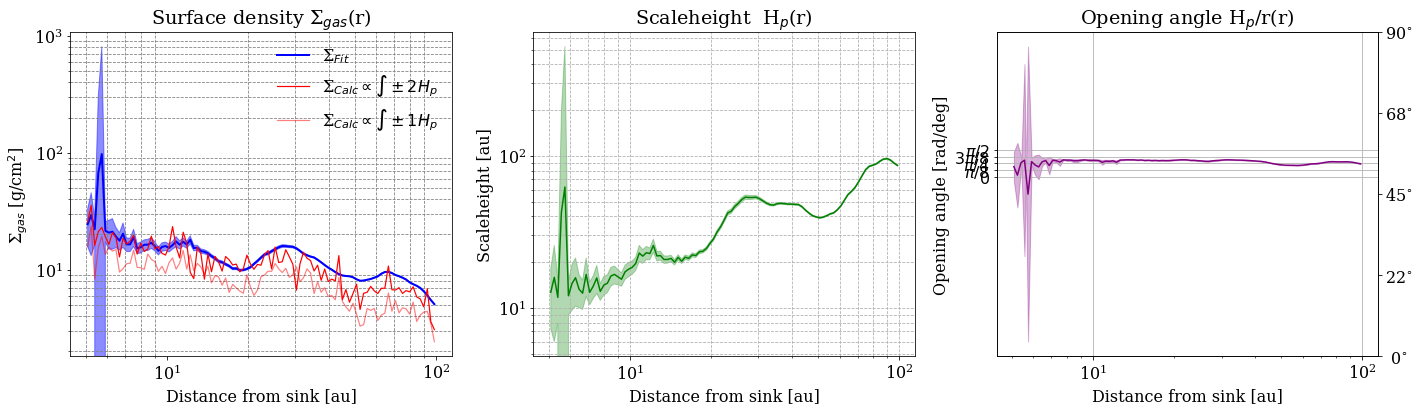

In [81]:
fig, axs = plt.subplots(1,3, figsize = (20, 6))


ax = axs[0]
ax.grid(which = 'minor', ls = '--', c = 'grey'); #ax.grid(which = 'major', ls = '-', c= 'grey')

ax.loglog(r_grid_mid * data.au_length, all_params[:,0], color = 'blue', label = 'Σ$_{Fit}$', lw = 2)
for i in reversed(range(1, 3)):
    ax.loglog(r_grid_mid * data.au_length, sigmas[i - 1], color = 'red', label = 'Σ$_{Calc}$'+f'$\propto\int\pm{i}H_p$', alpha = i/2, lw =1.2)
ax.fill_between(r_grid_mid * data.au_length, all_params[:,0] + all_err[:,0], all_params[:,0] -  all_err[:,0], alpha = 0.45, color = 'blue')
ax.set(ylabel = 'Σ$_{gas}$ [g/cm$^2$]', xlabel = 'Distance from sink [au]', title = 'Surface density Σ$_{gas}$(r)')
ax.legend(frameon = False)

ax = axs[1]
ax.grid(which = 'both', ls = '--')
ax.loglog(r_grid_mid * data.au_length, all_params[:,1], label = 'Scaleheight H$_p$', color = 'green')
ax.fill_between(r_grid_mid * data.au_length, all_params[:,1] + all_err[:,1], all_params[:,1] -  all_err[:,1], alpha = 0.3, color = 'green')
ax.set(ylabel = 'Scaleheight [au]', xlabel = 'Distance from sink [au]', title = 'Scaleheight  H$_p$(r)')

ax = axs[2]
φ =  np.sin(all_params[:,1] / (r_grid_mid * data.au_length))
σ_φ = np.cos(all_params[:,1] / (r_grid_mid * data.au_length)) * (r_grid_mid * data.au_length)**(-1) * all_err[:,1]
ax.grid()

ax.semilogx(r_grid_mid * data.au_length, φ, color = 'purple')
ax.fill_between(r_grid_mid * data.au_length, φ + σ_φ, φ - σ_φ, color = 'purple', alpha = 0.3)

#Values for ticks
values = np.linspace(0, np.pi/2, 5)
names = ['$0$', '$π/8$', '$π/4$', '$3π/8$', '$π/2$']
ax.set_yticks(values); ax.set_yticklabels(names)
ax2 = ax.twinx()
ax2.set_yticks(np.rad2deg(values))
ax2.set_yticklabels([f'{deg:2.0f}'+'$^{\circ}$' for deg in np.rad2deg(values)])

ax.set(ylabel = 'Opening angle [rad/deg]', xlabel = 'Distance from sink [au]', title = 'Opening angle H$_p$/r(r)')


plt.tight_layout()

In [82]:
np.vstack((np.sin(all_params[:,1] / (r_grid_mid * data.cgs_length)), np.cos(all_params[:,1] / (r_grid_mid * data.cgs_length)) * (r_grid_mid * data.cgs_length)**(-1) * all_err[:,1])).T

AttributeError: 'pipeline' object has no attribute 'cgs_length'

In [ ]:
print('STOP - Hammer time')

STOP - Hammer time


/tmp/ipykernel_1661514/701416366.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (8,8))


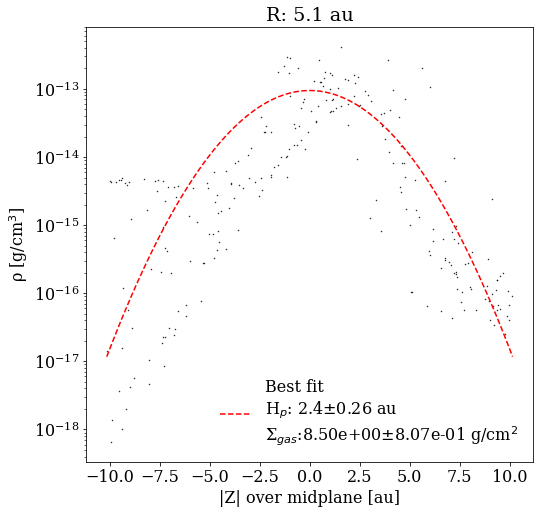

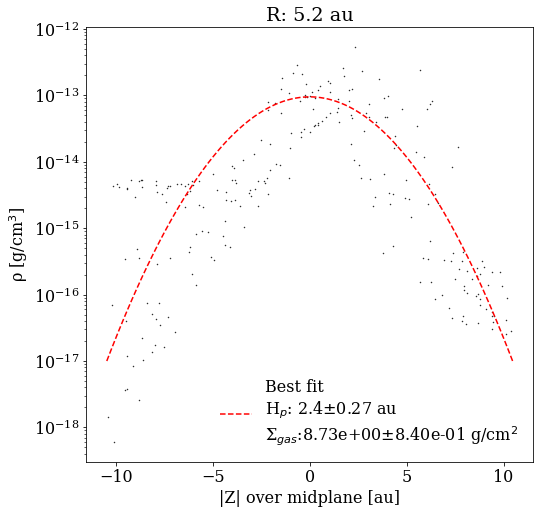

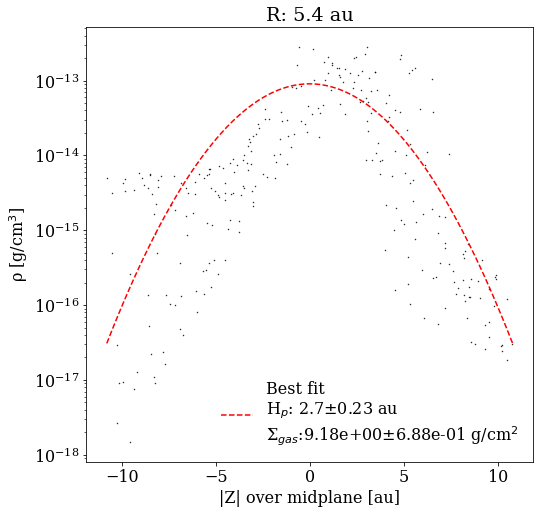

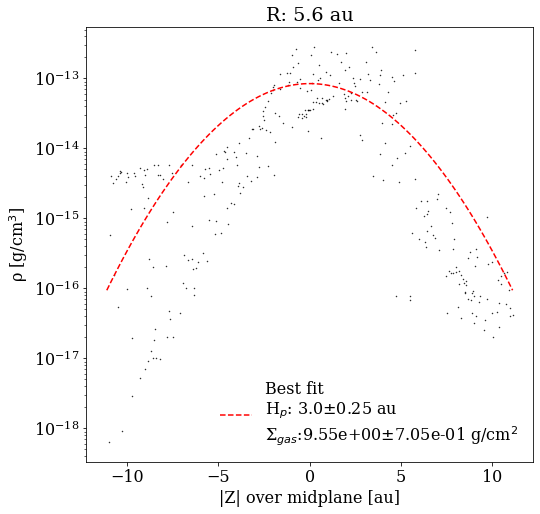

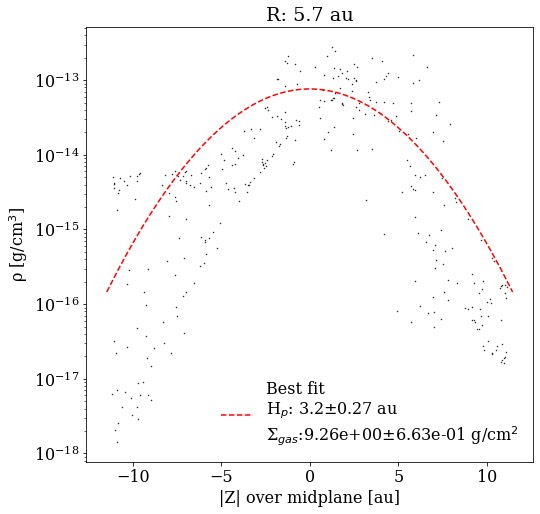

Error in callback <function flush_figures at 0x7ff94ee879d0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
for key in densities.keys():
    fig, axs = plt.subplots(figsize = (8,8))
    axs.set_yscale('log')
    axs.scatter(np.asarray(heights[key]), np.asarray(densities[key]), marker='.', s = 0.8, color = 'black')

    x = np.linspace(-2 * r_grid_mid[key] * data.cgs_length, 2 * r_grid_mid[key] * data.cgs_length, 100)
    Σ_param = all_params[key, 0] / data.sn.cgs.au
    y = Hp_func(x, Σ_param, all_params[key, 1])

    axs.semilogy(x, y, ls = '--', color = 'red', label = f'Best fit\nH$_p$: {all_params[key][1]:1.2}$\pm${all_err[key][1]:1.2f} au'+'\nΣ$_{gas}$:'+f'{all_params[key][0]:1.2e}$\pm${all_err[key][0]:1.2e} g/cm$^2$')
    axs.set(xlabel = '|Z| over midplane [au]', ylabel = 'ρ [g/cm$^3$]', title = f'R: {r_grid_mid[key] * data.cgs_length:2.1f} au')
    axs.legend(frameon = False)
    if key == 25: break